In [2]:
# Calculate scores for misaligned texts
import re
import os
import json

def detect_language(text):
    """
    Checks whether the majority of the letters in the input text are in the greek or the latin script
    It is used to identify whether the text is in greek or greeklish (latin script), in order to skip unnecessary conversions.

    Args:
        text (str): The input text

    Returns:
        script (str): The dominant script
    """
    # Filter out non-letter characters
    valid_characters = [char for char in text if char.isalpha()]
    
    # Count Greek and English letters
    greek_count = sum(1 for char in valid_characters if '\u0370' <= char <= '\u03FF' or '\u1F00' <= char <= '\u1FFF')
    english_count = sum(1 for char in valid_characters if '\u0041' <= char <= '\u005A' or '\u0061' <= char <= '\u007A')
    
    if(greek_count == 0 and english_count == 0):
        return "unknown"
    
    # If there is even a single latin letter, the text is considered to be in the latin script
    if(english_count > 0):
        return "latin"
    else:
        return "greek"


    # script = "greek" if greek_count >= english_count else "latin"
    # return script


def compare_bare_words(word1, word2):
    """
    Compares two words by removing punctation and making them lowercase
    """
    word1 = " ".join(re.findall("[a-zA-Z]+", word1.lower()))
    word2 = " ".join(re.findall("[a-zA-Z]+", word2.lower()))
    return word1 == word2

def calculate_scores_misaligned(original_text, predicted_text, gt_indices):
    TP = 0
    FP = 0
    FN = 0

    
    FP_words = []
    FN_words = []

    predicted_text = predicted_text.lower()
    
    indices_not_found = []
    
    for index in gt_indices:
        word = original_text.split(" ")[index].lower()
        stripped_word = " ".join(re.findall("[a-zA-Z]+", word))
        stripped_predicted_text = " ".join(re.findall("[a-zA-Z]+", predicted_text))
        
        # Check whether the word is in the predicted text
        if(stripped_word in stripped_predicted_text):
            TP += 1
        # If the word is not in the predicted text, it is a false negative
        else:
            print("original text: ", original_text)
            print("predicted text: ", predicted_text)
            print("False negative: ", stripped_word)
            FN += 1
            indices_not_found.append(index)
            FN_words.append(word)
     # Check for false positives
    original_english_words = [original_text.split(" ")[index].lower() for index in gt_indices]
    stripped_original_english_words = [" ".join(re.findall("[a-zA-Z]+", word)) for word in original_english_words]
    for i, word in enumerate(predicted_text.split(" ")):
        # only keep the letters
        stripped_word = " ".join(re.findall("[a-zA-Z]+", word))
        if detect_language(stripped_word) == "latin":
            if(stripped_word.lower() not in stripped_original_english_words):
                print("original text: ", original_text)
                print("predicted text: ", predicted_text)
                FP += 1
                FP_words.append(stripped_word.lower())
                print("False positive: ", word)

    
    return TP, FP, FN, FP_words, FN_words


def calculate_scores_aligned(original_text, predicted_text, gt_indices):
    TP = 0
    FP = 0
    FN = 0

    FP_words = []
    FN_words = []

    split_text = original_text.split(" ")
    split_predicted_text = predicted_text.split(" ")

    for gt_index in gt_indices:
        if(compare_bare_words(split_text[gt_index], split_predicted_text[gt_index])):
            TP += 1
            
        else:
            print("original text: ", original_text)
            print("predicted text: ", predicted_text)
            print("False negative: ", split_text[gt_index], ' -> ', split_predicted_text[gt_index])
            FN += 1
            FN_words.append(split_text[gt_index])
    
     # Check for false positives
    original_english_words = [original_text.split(" ")[index].lower() for index in gt_indices]
    stripped_original_english_words = [" ".join(re.findall("[a-zA-Z]+", word)) for word in original_english_words]
    for i, word in enumerate(predicted_text.split(" ")):
        # only keep the letters
        stripped_word = " ".join(re.findall("[a-zA-Z]+", word))
        if detect_language(stripped_word) == "latin":
            if(stripped_word.lower() not in stripped_original_english_words):
                print("original text: ", original_text)
                print("predicted text: ", predicted_text)
                FP += 1
                FP_words.append(stripped_word.lower())
                print("False positive: ", word)
    

        
    return TP, FP, FN, FP_words, FN_words

In [9]:
# original_text = {
#     "text" : "prepei na kanoume adjust sta kainouria guidelines",
#     "gt_indices": [3, 6]
# }

# predicted_text = "πρεπει να κανουμε adjust στα kainourgia guidelines"

# recall, precision = calculate_scores_misaligned(original_text["text"], predicted_text, original_text["gt_indices"])
# print("Recall: ", recall)
# print("Precision: ", precision)

In [4]:

def benchmark_llm(path="LLMs/LLM_data/llama-3.1-70b-versatile_0.0_data/", original_data_key = 'greeklish', predicted_data_key = 'greek'):
    llama_data = os.listdir(path)
    print(llama_data)


    precisions = []
    recalls = []

    TP_all = 0
    FP_all = 0
    FN_all = 0

    FP_words_all = []
    FN_words_all = []

    aligned = 0
    misaligned = 0

    for forum in llama_data:
        with open(path + forum, "r") as f:
            forum_data = json.load(f)
        
        # with open("forums_info/forums_sampled/" + forum, "r") as f:
        #     annotations_data = json.load(f)

        for annotation in forum_data:
            original_text = annotation[original_data_key]
            gt_indices = annotation["gt_indices"]
            # check if the annotation file is aligned with the LLM data
                
            predicted_text = annotation[predicted_data_key]

            # Check if the text is aligned

            if(len(original_text.split(" ")) == len(predicted_text.split(" "))):
                aligned += 1
                TP, FP, FN, FP_words, FN_words = calculate_scores_aligned(original_text, predicted_text, gt_indices)
            else:
                misaligned += 1
                TP, FP, FN, FP_words, FN_words  = calculate_scores_misaligned(original_text, predicted_text, gt_indices)
                

            # skip if the denominator is 0
            if(TP + FN == 0 or TP + FP == 0):
                continue

            TP_all += TP
            FP_all += FP
            FN_all += FN

            recall = TP / (TP + FN)
            precision = TP / (TP + FP)

            FP_words_all.extend(FP_words)
            FN_words_all.extend(FN_words)
            
            precisions.append(precision)
            recalls.append(recall)

    micro_average_precision = TP_all / (TP_all + FP_all)
    micro_average_recall = TP_all / (TP_all + FN_all)

    macro_average_precision = sum(precisions) / len(precisions)
    macro_average_recall = sum(recalls) / len(recalls)
    
    print("FP_words: ", FP_words_all)
    print("FN_words: ", FN_words_all)
    
    print("Aligned: ", aligned)
    print("Misaligned: ", misaligned)

    return micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall


In [5]:
from evaluate import load

def benchmark_llm_er(path):
    cer = load("cer")
    wer = load("wer")

    with open(path, "r") as f:
        data = json.load(f)
    
    original_texts = []
    predicted_texts = []

    for item in data:
        original_texts.append(item['mixed'])
        predicted_texts.append(item['greek_predicted'])

    cer_raw = cer.compute(predictions=predicted_texts, references=original_texts)
    wer_raw = wer.compute(predictions=predicted_texts, references=original_texts)
    
    return cer_raw, wer_raw


/home/sp1r05/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2024-10-29 16:21:15.536836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 16:21:16.448810: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 16:21:19.577542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object f

In [5]:
# Combine datasets
import json
import os

dataset1_forums = os.listdir("forums_info/forums_sampled/")
dataset2_forums = os.listdir("forums_info/forums_sampled2/")

for forum1, forum2 in zip(dataset1_forums, dataset2_forums):
    with open("forums_info/forums_sampled/" + forum1, "r") as f:
        data1 = json.load(f)
    
    with open("forums_info/forums_sampled2/" + forum2, "r") as f:
        data2 = json.load(f)
    
    data1.extend(data2)

    with open("forums_info/forums_sampled_combined/" + forum1, "w") as f:
        json.dump(data1, f)




In [13]:
    # Benchmark LLama
    
    micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/llama-3.1-70b-versatile_0.0_data_combined/")
    
    print(f"Average macro precision: {macro_average_precision}")
    print(f"Average macro recall: {macro_average_recall}")

   

    print(f"Average micro precision: {micro_average_precision}")
    print(f"Average micro recall: {micro_average_recall}")

['Προγραμματισμός_sample.json', 'Hardware_sample.json', 'Gadgets_sample.json', 'Λειτουργικά Συστήματα_sample.json', 'Ειδήσεις_sample.json', 'Ψυχαγωγία_sample.json', 'Software_sample.json', 'Διαδίκτυο_sample.json']
original text:  ena poly aplo pou mou ir8e ayti ti stigmi einai na to kaneis olo ena buton kai mesa na kaneis ta animation pou pi8anon na 8es.... apla kai meta ka8orizeis to hot shmeio tou button
predicted text:  ένα πολύ απλό που μου ήρθε αυτή τη στιγμή είναι να το κάνεις όλο ένα button και μέσα να κάνεις τα animation που πιθανόν να θες.... απλά και μετά καθορίζεις το hot σημείο του button
False negative:  buton  ->  button
original text:  Mia xara ide einai... eida demos einai polu kalh fash !
predicted text:  Μια χαρά ιδεί είναι... είδα δемо είναι πολύ καλή φάση !
False negative:  demos  ->  δемо
original text:  basika 0lew me to pu mpenei se mia selida na petaei to pop-p, xwris kapoios na prepei na pathse to click me, alla apla 0a balw to scriptaki gia automatic fwd, opot

In [14]:
# Benchmark GPT-4o

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/gpt-4o_0.0_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")



print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

['Προγραμματισμός_sample.json', 'Hardware_sample.json', 'Gadgets_sample.json', 'Λειτουργικά Συστήματα_sample.json', 'Ειδήσεις_sample.json', 'Ψυχαγωγία_sample.json', 'Software_sample.json', 'Διαδίκτυο_sample.json']
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  θα ήθελα κάνα site να κατεβάσω e books για borland c
False positive:  e
original text:  ena poly aplo pou mou ir8e ayti ti stigmi einai na to kaneis olo ena buton kai mesa na kaneis ta animation pou pi8anon na 8es.... apla kai meta ka8orizeis to hot shmeio tou button
predicted text:  ένα πολύ απλό που μου ήρθε αυτή τη στιγμή είναι να το κάνεις όλο ένα κουμπί και μέσα να κάνεις τα animation που πιθανόν να θες.... απλά και μετά καθορίζεις το hot σημείο του button
False negative:  buton  ->  κουμπί
original text:  Exo katevasei Siemens Mobility ToolKit (SMTK) apo Auto den kanei?
predicted text:  Έχω κατεβάσει Siemens Mobility ToolKit (SMTK) από Αυτό δεν κάνει?
False negative:  Auto  ->  Αυτό


In [18]:
# Benchmark GPT-4o-mini

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/gpt-4o-mini_0.0_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    


print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

['Προγραμματισμός_sample.json', 'Hardware_sample.json', 'Gadgets_sample.json', 'Λειτουργικά Συστήματα_sample.json', 'Ειδήσεις_sample.json', 'Ψυχαγωγία_sample.json', 'Software_sample.json', 'Διαδίκτυο_sample.json']
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  θα ήθελα κάνα site να κατεβάσω e books για borland c
False positive:  e
original text:  ena poly aplo pou mou ir8e ayti ti stigmi einai na to kaneis olo ena buton kai mesa na kaneis ta animation pou pi8anon na 8es.... apla kai meta ka8orizeis to hot shmeio tou button
predicted text:  ένα πολύ απλό που μου ήρθε αυτή τη στιγμή είναι να το κάνεις όλο ένα button και μέσα να κάνεις τα animation που πιθανόν να θες.... απλά και μετά καθορίζεις το hot σημείο του button
False negative:  buton  ->  button
original text:  Mia xara ide einai... eida demos einai polu kalh fash !
predicted text:  Μια χαρά ιδέα είναι... είδα δέμος είναι πολύ καλή φάση !
False negative:  demos  ->  δέμος
original text:  b

In [14]:
# Test greeklish2me

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/allgreek2me_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    


print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

['Προγραμματισμός_sample.json', 'Hardware_sample.json', 'Gadgets_sample.json', 'Λειτουργικά Συστήματα_sample.json', 'Ειδήσεις_sample.json', 'Ψυχαγωγία_sample.json', 'Software_sample.json', 'Διαδίκτυο_sample.json']
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia borland c
False positive:  tha
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia borland c
False positive:  ithela
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia borland c
False positive:  kana
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia borland c
False positive:  na
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e book

In [15]:
# Test llama-3.1-8b-instant

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/llama-3.1-8b-instant_0.0_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    


print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

['Προγραμματισμός_sample.json', 'Hardware_sample.json', 'Gadgets_sample.json', 'Λειτουργικά Συστήματα_sample.json', 'Ειδήσεις_sample.json', 'Ψυχαγωγία_sample.json', 'Software_sample.json', 'Διαδίκτυο_sample.json']
original text:  ena poly aplo pou mou ir8e ayti ti stigmi einai na to kaneis olo ena buton kai mesa na kaneis ta animation pou pi8anon na 8es.... apla kai meta ka8orizeis to hot shmeio tou button
predicted text:  ένα πολύ απλό που μου είπε ότι η στιγμή είναι να το κάνεις όλο ένα βούτυρο και μέσα να κάνεις τα animation που πήγαν να βγάλουν... απλά και μετά κατέβηκε το σχήμα του βουτύρου.
False negative:  buton
original text:  ena poly aplo pou mou ir8e ayti ti stigmi einai na to kaneis olo ena buton kai mesa na kaneis ta animation pou pi8anon na 8es.... apla kai meta ka8orizeis to hot shmeio tou button
predicted text:  ένα πολύ απλό που μου είπε ότι η στιγμή είναι να το κάνεις όλο ένα βούτυρο και μέσα να κάνεις τα animation που πήγαν να βγάλουν... απλά και μετά κατέβηκε το σχή

In [ ]:
# test llama-3.2-3b-preview

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/llama-3.2-3b-preview_0.0_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    


print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

In [ ]:
# test llama-3.2-1b-preview

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/llama-3.2-1b-preview_0.0_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    


print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

In [6]:
# test gemma2-9b-it_0.0_data

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/gemma2-9b-it_0.0_data_combined/")
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    


print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")


['Προγραμματισμός_sample.json', 'Hardware_sample.json', 'Gadgets_sample.json', 'Λειτουργικά Συστήματα_sample.json', 'Ειδήσεις_sample.json', 'Ψυχαγωγία_sample.json', 'Software_sample.json', 'Διαδίκτυο_sample.json']
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia books gia borland c 

False positive:  tha
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia books gia borland c 

False positive:  ithela
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia books gia borland c 

False positive:  kana
original text:  tha ithela kana site na katebaso e books gia borland c
predicted text:  tha ithela kana site na katebaso e books gia books gia borland c 

False positive:  na
original text:  tha ithela kana site na katebaso e books gia borland c
predicte

## Synthetic Data benchmarking



In [16]:
# Benchmark Llama on the synthetic data

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/llama-3.1-70b-versatile_0.0_synthetic_data_fixedPrompting/", original_data_key = 'greeklish', predicted_data_key = 'greek_predicted')
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    

print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")


cer_raw, wer_raw = benchmark_llm_er("LLMs/LLM_data/llama-3.1-70b-versatile_0.0_synthetic_data_fixedPrompting/synthetic_data_300_fixedPrompting.json")
print(f"CER_raw: {cer_raw}\n"
      f"WER_raw: {wer_raw}")

['synthetic_data_300_fixedPrompting.json']
original text:  Fronw oti, xari sto programma drasis ths voreiu dimension, mporume na auksisume ti statherotita kai thn asfaleia se whole thn epikratia ths Eirophs kai na enisxisume tin ikonomikh ke politikh anaptuxi ton boreiwn perioxwn tis Europe.
predicted text:  Φρόντισε ότι, χάρι στο πρόγραμμα δράσης της βόρειας διάσταση, μπορούμε να αυξήσουμε τη σταθερότητα και την ασφάλεια σε whole την επικράτεια της Ευρώπης και να ενισχύσουμε την οικονομική και πολιτική ανάπτυξη των βόρειων περιοχών της Ευρώπης.
False negative:  dimension,  ->  διάσταση,
original text:  Fronw oti, xari sto programma drasis ths voreiu dimension, mporume na auksisume ti statherotita kai thn asfaleia se whole thn epikratia ths Eirophs kai na enisxisume tin ikonomikh ke politikh anaptuxi ton boreiwn perioxwn tis Europe.
predicted text:  Φρόντισε ότι, χάρι στο πρόγραμμα δράσης της βόρειας διάσταση, μπορούμε να αυξήσουμε τη σταθερότητα και την ασφάλεια σε whole την επικράτει

In [17]:
# Benchmark GPT-4o on the synthetic data

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/gpt-4o_0.0_synthetic_data/", original_data_key = 'greeklish', predicted_data_key = 'greek_predicted')
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    

print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

cer_raw, wer_raw = benchmark_llm_er("LLMs/LLM_data/gpt-4o_0.0_synthetic_data/synthetic_data_300.json")
print(f"CER_raw: {cer_raw}\n"
      f"WER_raw: {wer_raw}")

['synthetic_data_300.json']
original text:  Fronw oti, xari sto programma drasis ths voreiu dimension, mporume na auksisume ti statherotita kai thn asfaleia se whole thn epikratia ths Eirophs kai na enisxisume tin ikonomikh ke politikh anaptuxi ton boreiwn perioxwn tis Europe.
predicted text:  Φρονώ ότι, χάρη στο πρόγραμμα δράσης της βόρειου διάστασης, μπορούμε να αυξήσουμε τη σταθερότητα και την ασφάλεια σε whole την επικράτεια της Ευρώπης και να ενισχύσουμε την οικονομική και πολιτική ανάπτυξη των βόρειων περιοχών της Europe.
False negative:  dimension,  ->  διάστασης,
original text:  To Eyropaϊko Kinovoulio, os to mono eklegmeno organo The Enosis, prepi kapote na expressions ousiastika tous eurwpeus polites kai na steilei ena ousiastiko mhnima katadikis auths tis politikhs, na apetisei anatroph aiths The politikis katapshfizodas aiton ton antilaϊko proϋpologismo litothtas.
predicted text:  Το Ευρωπαϊκό Κοινοβούλιο, ως το μόνο εκλεγμένο όργανο The Enosis, πρέπει κάποτε να expressions

In [19]:
# Benchmark GPT-4o-mini on the synthetic data

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/gpt-4o-mini_0.0_synthetic_data/", original_data_key = 'greeklish', predicted_data_key = 'greek_predicted')
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    
print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

cer_raw, wer_raw = benchmark_llm_er("LLMs/LLM_data/gpt-4o-mini_0.0_synthetic_data/synthetic_data_300.json")
print(f"CER_raw: {cer_raw}\n"
      f"WER_raw: {wer_raw}")

['synthetic_data_300.json']
original text:  Fronw oti, xari sto programma drasis ths voreiu dimension, mporume na auksisume ti statherotita kai thn asfaleia se whole thn epikratia ths Eirophs kai na enisxisume tin ikonomikh ke politikh anaptuxi ton boreiwn perioxwn tis Europe.
predicted text:  Φρόνw ότι, χάρη στο πρόγραμμα δράσης της βόρειου dimension, μπορούμε να αυξήσουμε τη σταθερότητα και την ασφάλεια σε whole την επικράτεια της Ειρώπης και να ενισχύσουμε την οικονομική και πολιτική ανάπτυξη των βόρειων περιοχών της Europe.
False positive:  Φρόνw
original text:  H egkekrimeni Directive upoxrewnei tora ta krath meli na parusiasun shedia, me ti bohthia twn opoiwn ua decrease oi ipoxrewtikes oriakes times tou ozontos eos to etos 2010, gia Reasons prostasias ton anthropon and tis blasthsis.
predicted text:  Η εγκεκριμένη Directive υποχρεώνει τώρα τα κράτη μέλη να παρουσιάσουν σχέδια, με τη βοήθεια των οποίων θα decrease οι υποχρεωτικές οριακές τιμές του όζοντος έως το έτος 2010, για Re

In [20]:
# Benchmark allgreektome on the synthetic data

micro_average_precision, micro_average_recall, macro_average_precision, macro_average_recall = benchmark_llm("LLMs/LLM_data/allgreek2me_synthetic_data/", original_data_key = 'greeklish', predicted_data_key = 'greek_predicted')
print(f"Average macro precision: {macro_average_precision}")
print(f"Average macro recall: {macro_average_recall}")
    

print(f"Average micro precision: {micro_average_precision}")
print(f"Average micro recall: {micro_average_recall}")

cer_raw, wer_raw = benchmark_llm_er("LLMs/LLM_data/allgreek2me_synthetic_data/synthetic_data_300.json")
print(f"CER_raw: {cer_raw}\n"
      f"WER_raw: {wer_raw}")

['synthetic_data_300.json']
original text:  Ean den yparhi katanalosh, tote ua katarreysi ke i paragogh.
predicted text:  Εάν δεν υπάρχει κατανάλωση, τότε θα κατάρρευση και i παραγωγή.
False positive:  i
original text:  H egkekrimeni Directive upoxrewnei tora ta krath meli na parusiasun shedia, me ti bohthia twn opoiwn ua decrease oi ipoxrewtikes oriakes times tou ozontos eos to etos 2010, gia Reasons prostasias ton anthropon and tis blasthsis.
predicted text:  Η εγκεκριμένη Directive υποχρεώνει τώρα τα κράτη meli να παρουσιάσουν σχέδια, με τι βοήθεια των οποιων θα decrease οι υποχρεωτικές οριακές τιμές του όζοντος έως το έτος 2010, για Reasons προστασίας τον ανθρώπων and τις βλάστησης.
False positive:  meli
original text:  The dikewma The asulu mporei omws na diatiriuei single efoson meioui kai eksalhfui i mass katahrhsh tou and i paranomi metanasteish.
predicted text:  The δικαίωμα The ασύλου μπορεί όμως να διατηρηθεί single εφόσον μειωθεί και εξαλειφθεί i mass κατάχρηση του and i πα

In [24]:
sc = [
94.31,
86.54,
94.79,
86.44,
97.39,
91.09,
96.85,
92.27,
92.27,
89.75,
93.71,
92.31,
80.41,
90.44,
77.09,
90.58,
72.15,
59.98,
70.09,
61.23
]

sc = [
94.85,
70.57,
94.03,
65.37,
98.22,
87.63,
97.84,
86.34,
88.49,
74.12,
73.21,
68.60,
85.73,
98.44,
84.10,
98.53
]

def f1(p, r):
    return (2*p*r)/(p+r)

for i in range(0, len(sc), 2):
    if((i/2)%2 == 0):
        print("macro")
    else:
        print("micro")
    print(f1(sc[i], sc[i+1]))

macro
80.92811630999879
micro
77.12347678795483
macro
92.6232832929782
micro
91.73097621891628
macro
80.67005473218128
micro
70.83006840138212
macro
91.64642667101047
micro
90.74492690138531


## Robustness Test

In [43]:
import matplotlib.pyplot as plt
import pandas as pd




models = ["gpt-4o", "gpt-4o-mini", 'llama-3.1-8b-instant', 'llama-3.1-70b-versatile', 'allgreek2me']

base_path = "LLMs/robustness_test/"

models_er = {}

# Error rate dataframe
er_df = pd.DataFrame(
    columns = models
)

percentages = [0.0, 0.05, 0.1, 0.15, 0.2]

for model in models:
    models_er[model] = dict.fromkeys(percentages)

    results = os.listdir(os.path.join(base_path, model))

    for result in results:
        percentage = float(result.split("_")[0])
        print(percentage)
        cer_raw, wer_raw = benchmark_llm_er(os.path.join(base_path, model, result))

        models_er[model][percentage] = (cer_raw, wer_raw)


print(models_er)

0.15
0.05
0.1
0.2
0.0
0.15
0.05
0.1
0.2
0.0
0.05
0.15
0.1
0.2
0.0
0.15
0.1
0.2
0.0
0.05
0.0
0.15
0.2
0.1
0.05
{'gpt-4o': {0.0: (0.009864638599180972, 0.03509942613105565), 0.05: (0.014765886963196381, 0.042306152408914985), 0.1: (0.022776132722183914, 0.056986520752702524), 0.15: (0.021546132641478838, 0.05178166288535967), 0.2: (0.028877854206520413, 0.0660616575470439)}, 'gpt-4o-mini': {0.0: (0.036049303019910835, 0.09448818897637795), 0.05: (0.04672160950187856, 0.10623248365140799), 0.1: (0.06396787409240255, 0.1295876151074336), 0.15: (0.08614399221663693, 0.16054984652342186), 0.2: (0.09383776303471855, 0.17910049379420792)}, 'llama-3.1-8b-instant': {0.0: (0.17631276351092373, 0.3142933404510877), 0.05: (0.20700521148951642, 0.3488589350060056), 0.1: (1.8030057193850646, 1.9009742426264513), 0.15: (0.2845184044105724, 0.47911383958361137), 0.2: (0.29779396800846597, 0.4618977712531696)}, 'llama-3.1-70b-versatile': {0.0: (0.060821851485747716, 0.1423995729347391), 0.05: (0.0729613

gpt-4o
[0.0, 0.05, 0.1, 0.15, 0.2]
dict_values([(0.009864638599180972, 0.03509942613105565), (0.014765886963196381, 0.042306152408914985), (0.022776132722183914, 0.056986520752702524), (0.021546132641478838, 0.05178166288535967), (0.028877854206520413, 0.0660616575470439)])
[0.009864638599180972, 0.014765886963196381, 0.022776132722183914, 0.021546132641478838, 0.028877854206520413]
gpt-4o-mini
[0.0, 0.05, 0.1, 0.15, 0.2]
dict_values([(0.036049303019910835, 0.09448818897637795), (0.04672160950187856, 0.10623248365140799), (0.06396787409240255, 0.1295876151074336), (0.08614399221663693, 0.16054984652342186), (0.09383776303471855, 0.17910049379420792)])
[0.036049303019910835, 0.04672160950187856, 0.06396787409240255, 0.08614399221663693, 0.09383776303471855]
llama-3.1-70b-versatile
[0.0, 0.05, 0.1, 0.15, 0.2]
dict_values([(0.060821851485747716, 0.1423995729347391), (0.07296137339055794, 0.14903846153846154), (0.09915628929542043, 0.18697450954223943), (0.11243311172369061, 0.213532630455

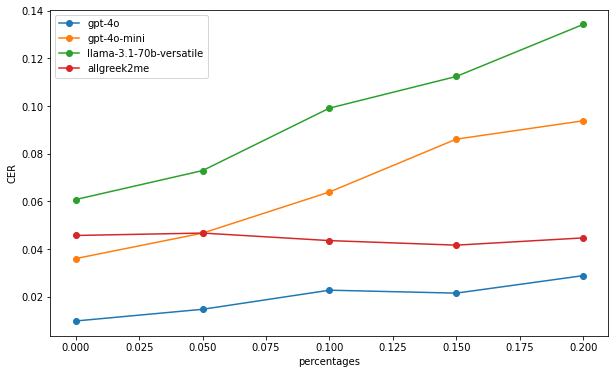

gpt-4o
[0.0, 0.05, 0.1, 0.15, 0.2]
dict_values([(0.009864638599180972, 0.03509942613105565), (0.014765886963196381, 0.042306152408914985), (0.022776132722183914, 0.056986520752702524), (0.021546132641478838, 0.05178166288535967), (0.028877854206520413, 0.0660616575470439)])
[0.009864638599180972, 0.014765886963196381, 0.022776132722183914, 0.021546132641478838, 0.028877854206520413]
gpt-4o-mini
[0.0, 0.05, 0.1, 0.15, 0.2]
dict_values([(0.036049303019910835, 0.09448818897637795), (0.04672160950187856, 0.10623248365140799), (0.06396787409240255, 0.1295876151074336), (0.08614399221663693, 0.16054984652342186), (0.09383776303471855, 0.17910049379420792)])
[0.036049303019910835, 0.04672160950187856, 0.06396787409240255, 0.08614399221663693, 0.09383776303471855]
llama-3.1-70b-versatile
[0.0, 0.05, 0.1, 0.15, 0.2]
dict_values([(0.060821851485747716, 0.1423995729347391), (0.07296137339055794, 0.14903846153846154), (0.09915628929542043, 0.18697450954223943), (0.11243311172369061, 0.213532630455

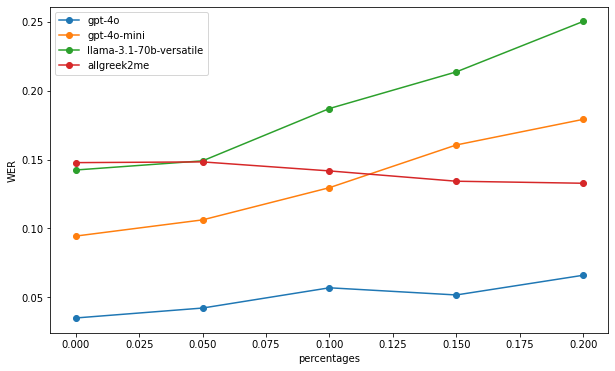

In [58]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'


percentages = [0.0, 0.05, 0.1, 0.15, 0.2]


# CER
plt.figure(figsize=(10, 6))
for model in list(models_er):
    if(model == 'llama-3.1-8b-instant'):
        continue
    # percentages = [float(percentage) for percentage in models_er[model].keys()]
    print(model)
    print(percentages)
    print(models_er[model].values())
    print([cer for cer, wer in models_er[model].values()])
    plt.plot(percentages, [cer for cer, wer in models_er[model].values()], marker='o', label=model)

    # plt.scatter(percentages, [wer for cer, wer in models_er[model].values()], marker='o', label=model)
plt.xlabel("percentages")
plt.ylabel("CER")
plt.legend()
plt.savefig('plots/robustness_cer.png')
plt.show()



# CER
plt.figure(figsize=(10, 6))
for model in list(models_er):
    if(model == 'llama-3.1-8b-instant'):
        continue
    # percentages = [float(percentage) for percentage in models_er[model].keys()]
    print(model)
    print(percentages)
    print(models_er[model].values())
    print([cer for cer, wer in models_er[model].values()])
    plt.plot(percentages, [wer for cer, wer in models_er[model].values()], marker='o', label=model)

    # plt.scatter(percentages, [wer for cer, wer in models_er[model].values()], marker='o', label=model)
plt.xlabel("percentages")
plt.ylabel("WER")
plt.legend()
plt.savefig('plots/robustness_wer.png')
plt.show()
